<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Natural Language Processing</h1>
<h1>Sequence Modeling</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import gzip
from collections import Counter
from pprint import pprint
import time

import random

import pandas as pd
import numpy as np
np.random.seed(42)

import matplotlib
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm
tqdm.pandas()

RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)

import torch
torch.manual_seed(RANDOM_SEED)

import torch.nn as nn
import torch.nn.functional as F

import torchtext
from torchtext.data import Field, BucketIterator, TabularDataset

from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import torchview
from torchview import draw_graph

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.12.3

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit

Git hash: 9c8c00758f3a2fa8e55e08f5aad405a157ca5dd2

pandas    : 2.2.3
matplotlib: 3.8.0
torchtext : 0.6.0
torch     : 2.3.0
numpy     : 1.26.4
watermark : 2.4.3
torchview : 0.2.6



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Load the Dataset

Define the text and label fields

In [4]:
TEXT = Field(tokenize='spacy', tokenizer_language='en_core_web_sm')
LABEL = torchtext.data.LabelField(dtype=torch.long)

Load the dataset with the proper schema

In [5]:
fields = [('TEXT_COLUMN_NAME', TEXT), ('LABEL_COLUMN_NAME', LABEL)]

dataset = TabularDataset(path='data/IMDB Dataset.csv', format='csv', skip_header=True, fields=fields)

Split the dataset into training, validation, and test partitions:

In [6]:
X_train, X_test = dataset.split(split_ratio=[0.8, 0.2],random_state=random.seed(RANDOM_SEED))
X_train, X_validation = X_train.split(split_ratio=[0.85, 0.15],random_state=random.seed(RANDOM_SEED))

In [7]:
print('Shape of training data:', len(X_train))
print('Shape of test data:', len(X_test))
print('Shape of validation data:', len(X_validation))

Shape of training data: 34000
Shape of test data: 10000
Shape of validation data: 6000


## Build Vocabulary

Build the vocabulary based on the top "vocabulary_size" words:

In [8]:
vocabulary_size = 20_000

In [9]:
TEXT.build_vocab(X_train, max_size=vocabulary_size)
LABEL.build_vocab(X_train)

print(f'Vocabulary size: {len(TEXT.vocab)}')
print(f'Number of classes: {len(LABEL.vocab)}')

Vocabulary size: 20002
Number of classes: 2


## Define Data Loaders

In [10]:
batch_size = 128
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [11]:
train_loader, valid_loader, test_loader = BucketIterator.splits((X_train, X_validation, X_test),
         batch_size=batch_size,
         sort_within_batch=False,
         sort_key=lambda x: len(x.TEXT_COLUMN_NAME),
         device=device
    )

Finally, we are ready to define our models

# Simple RNN model

As the structure of the model is the same for RNN, GRU, and LSTMs, we implement just one of them for demonstration purposes. We can easily plugin another type of layer as needed

In [12]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_size, hidden_size, output_size):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size)        
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, text):        
        embedded = self.embedding(text)
        output, (hidden, cell) = self.rnn(embedded)
        hidden.squeeze_(0)        
        output = self.fc(hidden)
        
        return output

In [13]:
embedding_size = 128
hidden_size = 256
num_classes = 2

In [14]:
model = RNN(len(TEXT.vocab), # vocabulary_size + 2 for <pad> and <unk>
            embedding_size,
            hidden_size,
            num_classes 
           )

In [15]:
print(model)

RNN(
  (embedding): Embedding(20002, 128)
  (rnn): LSTM(128, 256)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [16]:
learning_rate = 0.005
n_epochs = 15

In [17]:
model = model.to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

## Training

In [18]:
def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            loss = F.cross_entropy(logits, targets)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
            
    return correct_pred.float()/num_examples * 100, loss

Based on this [notebook](https://github.com/rasbt/stat453-deep-learning-ss21/tree/main/L15)

In [19]:
start_time = time.time()

history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'epochs': n_epochs
    }

for epoch in range(n_epochs):
    model.train()
    for batch_idx, batch_data in tqdm(enumerate(train_loader), 
                                      total=len(train_loader), 
                                      desc='Epoch: %u' % (epoch+1),
                                      leave=True):
        
        text = batch_data.TEXT_COLUMN_NAME.to(device)
        labels = batch_data.LABEL_COLUMN_NAME.to(device)

        # Forward pass
        logits = model(text)
        
        # Back propagation
        loss = F.cross_entropy(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        
        # update weights
        optimizer.step()
        
        if not batch_idx % 50:
            print (f'Epoch: {epoch+1:03d}/{n_epochs:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} | '
                   f'Loss: {loss:.4f}')

    with torch.set_grad_enabled(False):
        print(f'training accuracy: '
              f'{compute_accuracy(model, train_loader, device)[0]:.2f}%'
              f'\nvalid accuracy: '
              f'{compute_accuracy(model, valid_loader, device)[0]:.2f}%')
    
    history['train_loss'].append(loss.to('cpu').detach().numpy())
    history['train_acc'].append(compute_accuracy(model, train_loader, device)[0].to('cpu').detach().numpy())
    
    val_acc, val_loss = compute_accuracy(model, valid_loader, device)
    
    history['val_acc'].append(val_acc.to('cpu').detach().numpy())
    history['val_loss'].append(val_loss.to('cpu').detach().numpy())

    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    
print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
print(f'Test accuracy: {compute_accuracy(model, test_loader, device)[0]:.2f}%')

Epoch: 1:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 001/015 | Batch 000/266 | Loss: 0.7136
Epoch: 001/015 | Batch 050/266 | Loss: 0.6994
Epoch: 001/015 | Batch 100/266 | Loss: 0.6898
Epoch: 001/015 | Batch 150/266 | Loss: 0.6926
Epoch: 001/015 | Batch 200/266 | Loss: 0.6961
Epoch: 001/015 | Batch 250/266 | Loss: 0.6951
training accuracy: 49.94%
valid accuracy: 49.82%
Time elapsed: 1.06 min


Epoch: 2:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 002/015 | Batch 000/266 | Loss: 0.6954
Epoch: 002/015 | Batch 050/266 | Loss: 0.6933
Epoch: 002/015 | Batch 100/266 | Loss: 0.6932
Epoch: 002/015 | Batch 150/266 | Loss: 0.6926
Epoch: 002/015 | Batch 200/266 | Loss: 0.6930
Epoch: 002/015 | Batch 250/266 | Loss: 0.6915
training accuracy: 50.14%
valid accuracy: 49.38%
Time elapsed: 2.04 min


Epoch: 3:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 003/015 | Batch 000/266 | Loss: 0.6938
Epoch: 003/015 | Batch 050/266 | Loss: 0.6949
Epoch: 003/015 | Batch 100/266 | Loss: 0.6908
Epoch: 003/015 | Batch 150/266 | Loss: 0.6959
Epoch: 003/015 | Batch 200/266 | Loss: 0.6924
Epoch: 003/015 | Batch 250/266 | Loss: 0.6910
training accuracy: 50.25%
valid accuracy: 49.63%
Time elapsed: 2.99 min


Epoch: 4:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 004/015 | Batch 000/266 | Loss: 0.6919
Epoch: 004/015 | Batch 050/266 | Loss: 0.6913
Epoch: 004/015 | Batch 100/266 | Loss: 0.6991
Epoch: 004/015 | Batch 150/266 | Loss: 0.6940
Epoch: 004/015 | Batch 200/266 | Loss: 0.6953
Epoch: 004/015 | Batch 250/266 | Loss: 0.6928
training accuracy: 50.09%
valid accuracy: 50.45%
Time elapsed: 3.85 min


Epoch: 5:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 005/015 | Batch 000/266 | Loss: 0.6930
Epoch: 005/015 | Batch 050/266 | Loss: 0.6906
Epoch: 005/015 | Batch 100/266 | Loss: 0.6884
Epoch: 005/015 | Batch 150/266 | Loss: 0.6900
Epoch: 005/015 | Batch 200/266 | Loss: 0.6895
Epoch: 005/015 | Batch 250/266 | Loss: 0.6922
training accuracy: 50.39%
valid accuracy: 50.07%
Time elapsed: 4.70 min


Epoch: 6:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 006/015 | Batch 000/266 | Loss: 0.6860
Epoch: 006/015 | Batch 050/266 | Loss: 0.6872
Epoch: 006/015 | Batch 100/266 | Loss: 0.6904
Epoch: 006/015 | Batch 150/266 | Loss: 0.6873
Epoch: 006/015 | Batch 200/266 | Loss: 0.6886
Epoch: 006/015 | Batch 250/266 | Loss: 0.6975
training accuracy: 50.15%
valid accuracy: 50.95%
Time elapsed: 5.57 min


Epoch: 7:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 007/015 | Batch 000/266 | Loss: 0.6876
Epoch: 007/015 | Batch 050/266 | Loss: 0.6885
Epoch: 007/015 | Batch 100/266 | Loss: 0.6894
Epoch: 007/015 | Batch 150/266 | Loss: 0.6884
Epoch: 007/015 | Batch 200/266 | Loss: 0.6939
Epoch: 007/015 | Batch 250/266 | Loss: 0.6451
training accuracy: 68.65%
valid accuracy: 66.77%
Time elapsed: 6.43 min


Epoch: 8:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 008/015 | Batch 000/266 | Loss: 0.5576
Epoch: 008/015 | Batch 050/266 | Loss: 0.6149
Epoch: 008/015 | Batch 100/266 | Loss: 0.4773
Epoch: 008/015 | Batch 150/266 | Loss: 0.3983
Epoch: 008/015 | Batch 200/266 | Loss: 0.3978
Epoch: 008/015 | Batch 250/266 | Loss: 0.5196
training accuracy: 87.54%
valid accuracy: 83.55%
Time elapsed: 7.31 min


Epoch: 9:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 009/015 | Batch 000/266 | Loss: 0.2548
Epoch: 009/015 | Batch 050/266 | Loss: 0.2753
Epoch: 009/015 | Batch 100/266 | Loss: 0.4325
Epoch: 009/015 | Batch 150/266 | Loss: 0.3712
Epoch: 009/015 | Batch 200/266 | Loss: 0.4064
Epoch: 009/015 | Batch 250/266 | Loss: 0.2854
training accuracy: 90.88%
valid accuracy: 85.28%
Time elapsed: 8.21 min


Epoch: 10:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 010/015 | Batch 000/266 | Loss: 0.1848
Epoch: 010/015 | Batch 050/266 | Loss: 0.1800
Epoch: 010/015 | Batch 100/266 | Loss: 0.2642
Epoch: 010/015 | Batch 150/266 | Loss: 0.2920
Epoch: 010/015 | Batch 200/266 | Loss: 0.2054
Epoch: 010/015 | Batch 250/266 | Loss: 0.2201
training accuracy: 93.53%
valid accuracy: 86.18%
Time elapsed: 9.12 min


Epoch: 11:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 011/015 | Batch 000/266 | Loss: 0.1547
Epoch: 011/015 | Batch 050/266 | Loss: 0.1785
Epoch: 011/015 | Batch 100/266 | Loss: 0.1617
Epoch: 011/015 | Batch 150/266 | Loss: 0.0838
Epoch: 011/015 | Batch 200/266 | Loss: 0.2815
Epoch: 011/015 | Batch 250/266 | Loss: 0.2952
training accuracy: 95.04%
valid accuracy: 86.00%
Time elapsed: 9.93 min


Epoch: 12:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 012/015 | Batch 000/266 | Loss: 0.1977
Epoch: 012/015 | Batch 050/266 | Loss: 0.1446
Epoch: 012/015 | Batch 100/266 | Loss: 0.1537
Epoch: 012/015 | Batch 150/266 | Loss: 0.1356
Epoch: 012/015 | Batch 200/266 | Loss: 0.2212
Epoch: 012/015 | Batch 250/266 | Loss: 0.0900
training accuracy: 96.53%
valid accuracy: 86.62%
Time elapsed: 10.70 min


Epoch: 13:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 013/015 | Batch 000/266 | Loss: 0.1361
Epoch: 013/015 | Batch 050/266 | Loss: 0.0600
Epoch: 013/015 | Batch 100/266 | Loss: 0.0953
Epoch: 013/015 | Batch 150/266 | Loss: 0.1170
Epoch: 013/015 | Batch 200/266 | Loss: 0.2049
Epoch: 013/015 | Batch 250/266 | Loss: 0.0634
training accuracy: 97.55%
valid accuracy: 86.08%
Time elapsed: 11.47 min


Epoch: 14:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 014/015 | Batch 000/266 | Loss: 0.0310
Epoch: 014/015 | Batch 050/266 | Loss: 0.1754
Epoch: 014/015 | Batch 100/266 | Loss: 0.0735
Epoch: 014/015 | Batch 150/266 | Loss: 0.1243
Epoch: 014/015 | Batch 200/266 | Loss: 0.1415
Epoch: 014/015 | Batch 250/266 | Loss: 0.0495
training accuracy: 98.08%
valid accuracy: 86.80%
Time elapsed: 12.25 min


Epoch: 15:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 015/015 | Batch 000/266 | Loss: 0.0661
Epoch: 015/015 | Batch 050/266 | Loss: 0.0615
Epoch: 015/015 | Batch 100/266 | Loss: 0.0413
Epoch: 015/015 | Batch 150/266 | Loss: 0.0564
Epoch: 015/015 | Batch 200/266 | Loss: 0.0986
Epoch: 015/015 | Batch 250/266 | Loss: 0.0373
training accuracy: 98.67%
valid accuracy: 86.52%
Time elapsed: 13.02 min
Total Training Time: 13.02 min
Test accuracy: 87.29%


In [20]:
def plot_history(history):    
    fig, ax_lst = plt.subplots(1, 2, sharex=True, sharey=False)
    
    epochs = range(history['epochs'])
    
    ax_lst[0].plot(epochs, history['train_loss'], label='Training')
    ax_lst[0].plot(epochs, history['val_loss'], label='Testing')
    ax_lst[0].set_ylabel('Loss')
    ax_lst[0].set_xlabel('Epoch')
    ax_lst[0].set_xticks(epochs)
    
    ax_lst[1].plot(epochs, history['train_acc'], label='Training')
    ax_lst[1].plot(epochs, history['val_acc'], label='Testing')
    ax_lst[1].set_ylabel('Accuracy')
    ax_lst[1].set_xlabel('Epoch')
    ax_lst[1].set_xticks(epochs)

    ax_lst[1].legend()
    
    fig.tight_layout()

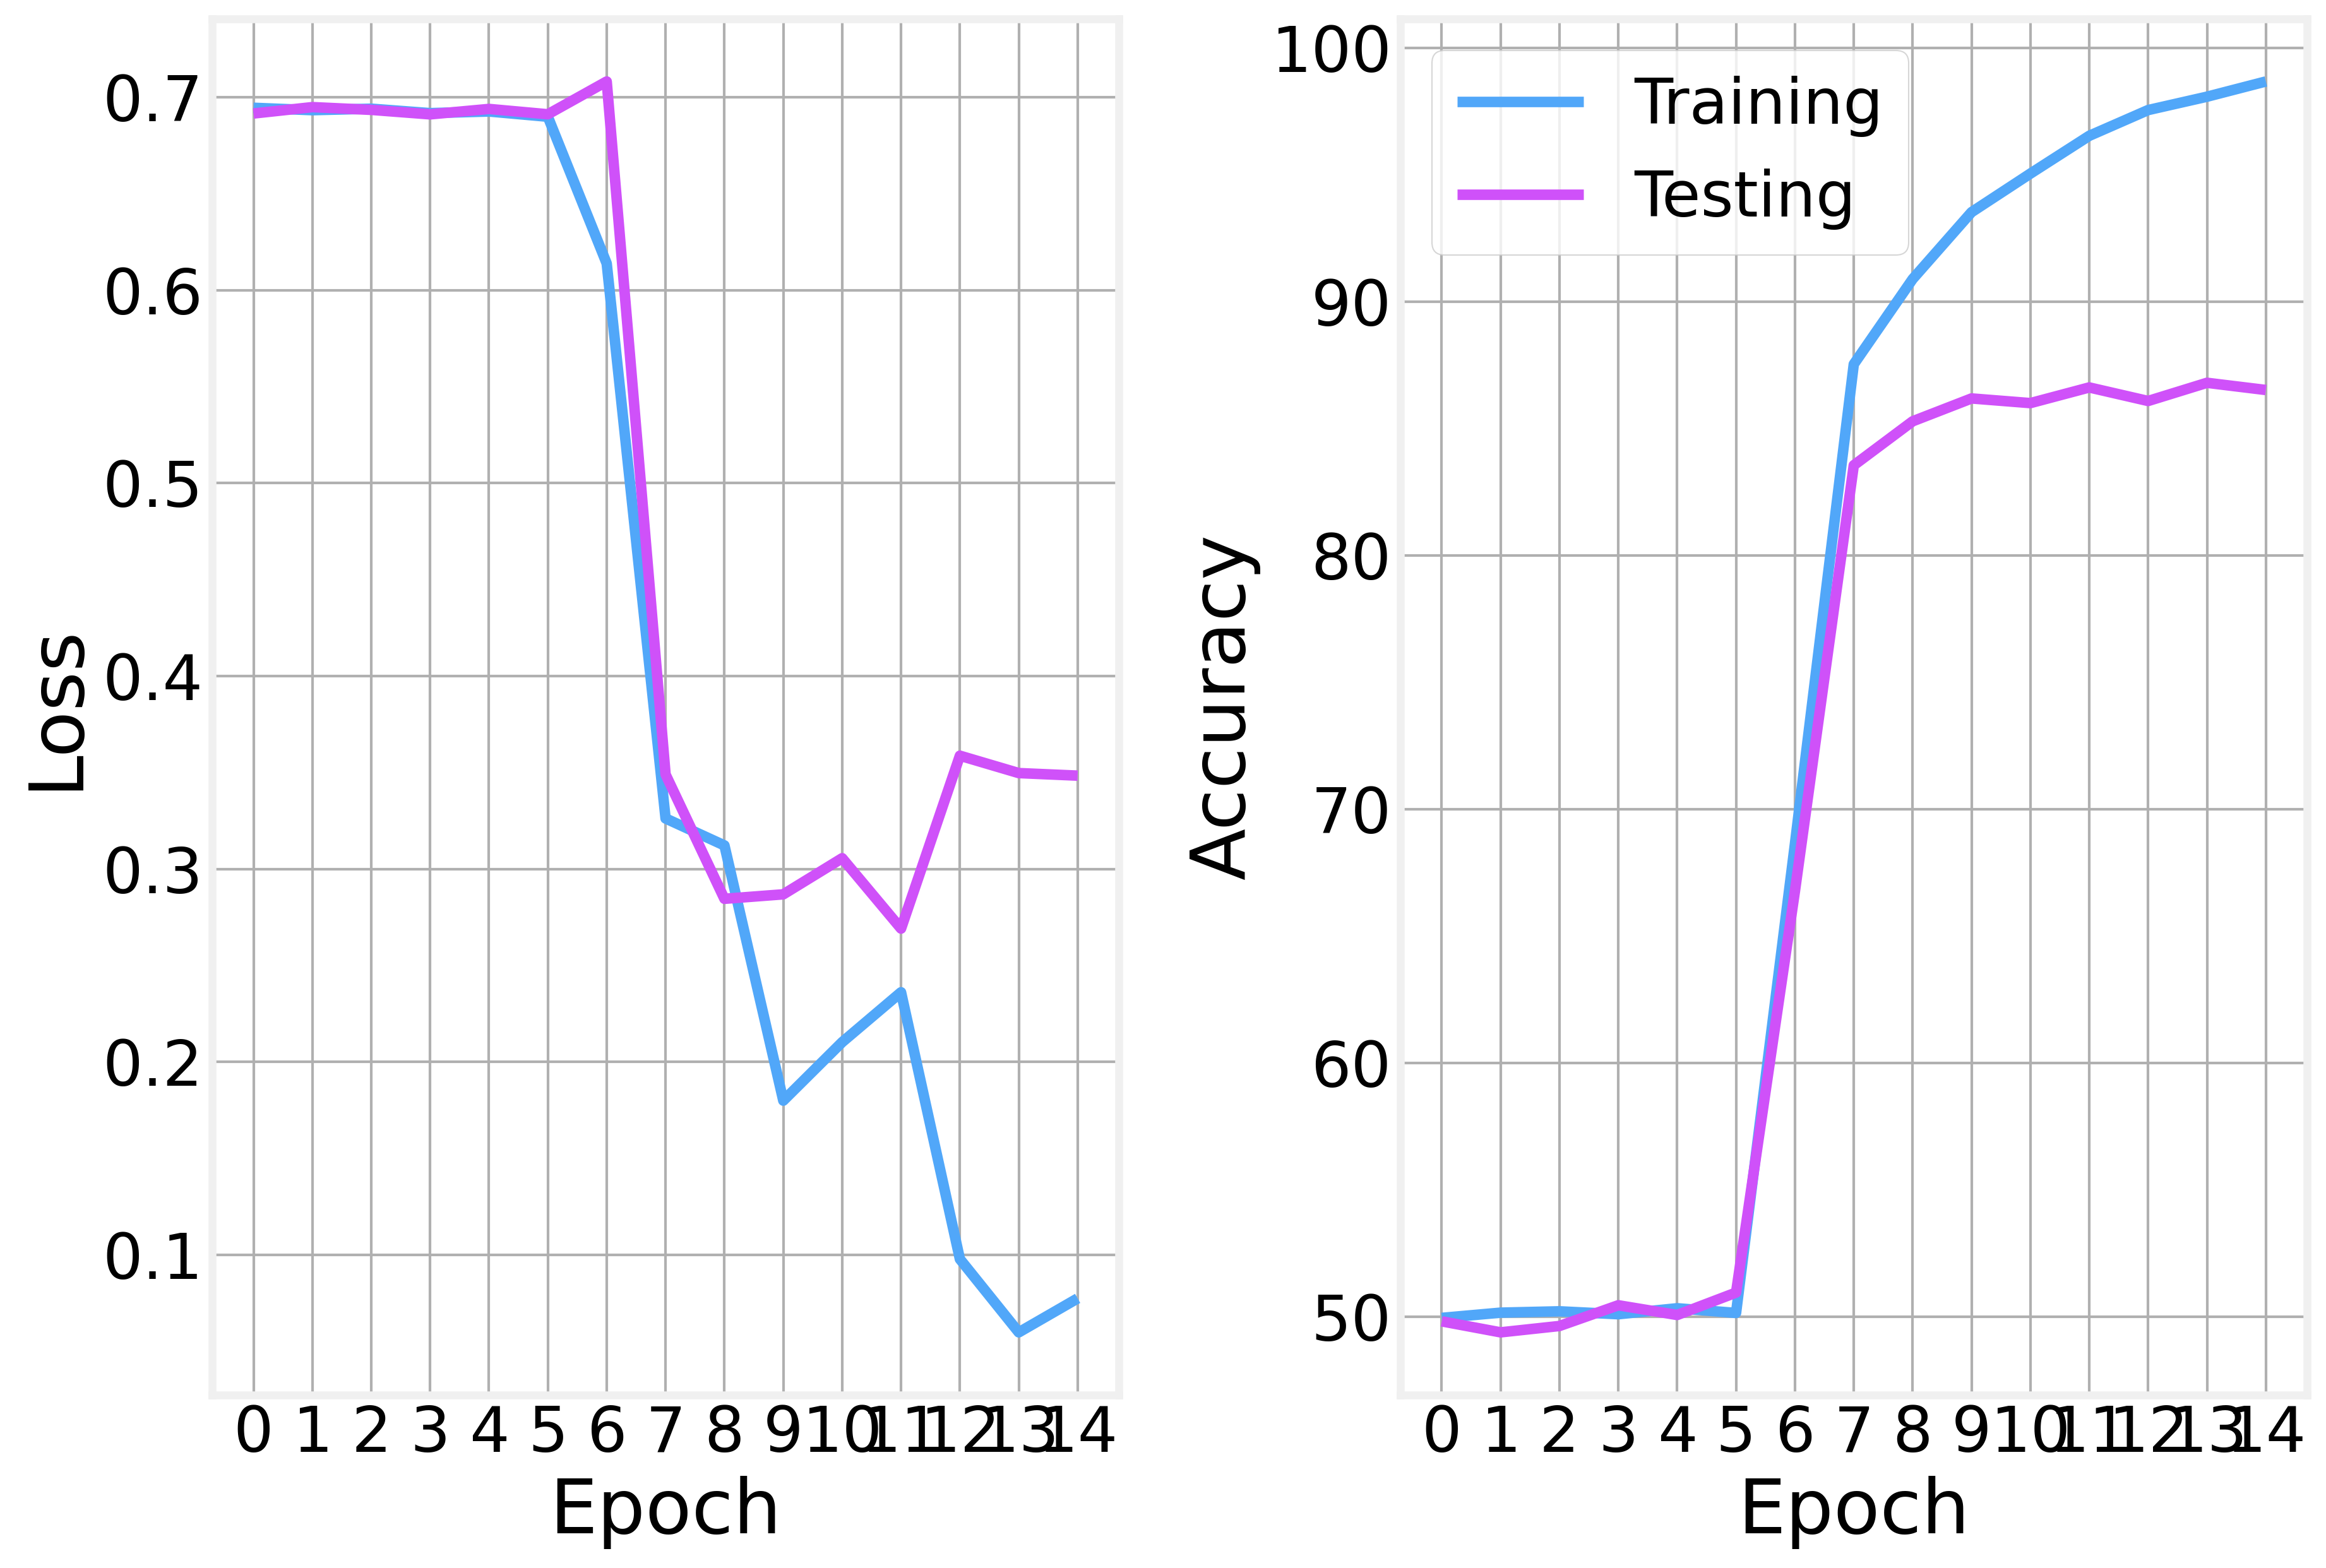

In [21]:
plot_history(history)

<center>
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</center>